In [1]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch

# loading the bert model
model_path = '../Model/sentiment_bert'
tokenizer = BertTokenizer.from_pretrained(model_path)
bert_model = BertForSequenceClassification.from_pretrained(model_path)
bert_model.eval()  # Inference mode, no parameter update

C:\Users\jsj31\AppData\Roaming\Python\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.3, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.3, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [3]:
import torch.nn as nn
import torch.nn.functional as F

# input: BERT output（logits），output: softmax P，For sampling action
class PolicyNetwork(nn.Module):
    def __init__(self, input_dim=768, hidden_dim=128, output_dim=3):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return F.softmax(self.fc2(x), dim=-1)

# Initialize the policy network
policy_net = PolicyNetwork()
policy_optimizer = torch.optim.Adam(policy_net.parameters(), lr=1e-4)

In [4]:
import pandas as pd
train_data = pd.read_csv("../Dataset/train_preprocessed.csv")
texts = train_data["Phrase"].astype(str).tolist()
labels = train_data["Sentiment"].tolist()

In [5]:
from torch.utils.data import Dataset, DataLoader

class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoded = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors='pt'
        )
        return encoded['input_ids'].squeeze(), encoded['attention_mask'].squeeze(), self.labels[idx]

In [6]:
dataset = TextDataset(texts, labels, tokenizer)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

In [8]:
from transformers import BertConfig


config = BertConfig.from_pretrained(model_path, output_hidden_states=True)
bert_model = BertForSequenceClassification.from_pretrained(model_path, config=config).to(device)
policy_net = PolicyNetwork().to(device)

In [9]:
from torch.distributions import Categorical
from transformers import BertConfig

# Setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Load BERT with hidden states
config = BertConfig.from_pretrained(model_path, output_hidden_states=True)
bert_model = BertForSequenceClassification.from_pretrained(model_path, config=config).to(device)
policy_net = PolicyNetwork().to(device)

num_epochs = 4
losses = []
accuracies = []

bert_model.eval()

for epoch in range(num_epochs):
    total_loss = 0
    correct = 0
    total = 0

    for input_ids, attention_mask, labels in dataloader:
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            output = bert_model(input_ids=input_ids, attention_mask=attention_mask)
            hidden_states = output.hidden_states[-1]              # [batch_size, seq_len, hidden_dim]
            cls_embeddings = hidden_states[:, 0, :].detach()      # [CLS] token embeddings

        # Get action probabilities from policy network
        action_probs = policy_net(cls_embeddings)
        dist = Categorical(action_probs)
        actions = dist.sample()

        # Improved reward signal: +2 for correct, -0.2 for incorrect
        rewards = torch.where(actions == labels,
                              torch.tensor(2.0, device=device),
                              torch.tensor(-0.2, device=device))

        # Normalize rewards for more stable training
        rewards = (rewards - rewards.mean()) / (rewards.std() + 1e-8)

        # Track accuracy
        correct += (actions == labels).sum().item()
        total += len(labels)

        # Policy Gradient loss
        log_probs = dist.log_prob(actions)
        loss = -(log_probs * rewards).mean()

        policy_optimizer.zero_grad()
        loss.backward()
        policy_optimizer.step()

        total_loss += loss.item()

    acc = correct / total
    losses.append(total_loss)
    accuracies.append(acc)
    print(f"Epoch {epoch+1}: Loss = {total_loss:.4f}, Accuracy = {acc:.4f}")


Using device: cuda
Epoch 1: Loss = 351.3484, Accuracy = 0.2133
Epoch 2: Loss = 352.4369, Accuracy = 0.2122
Epoch 3: Loss = 352.7056, Accuracy = 0.2120
Epoch 4: Loss = 354.8450, Accuracy = 0.2115


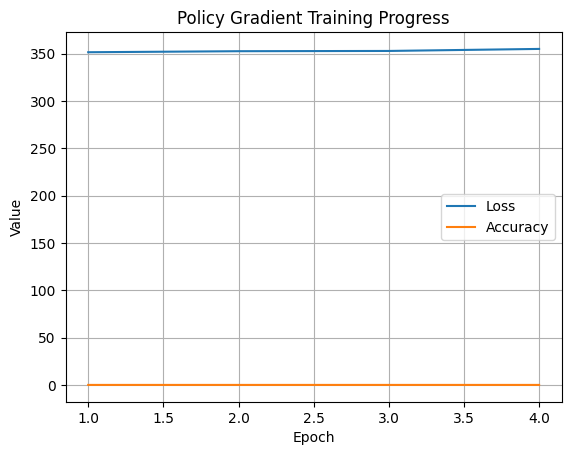

In [10]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(range(1, num_epochs + 1), losses, label='Loss')
plt.plot(range(1, num_epochs + 1), accuracies, label='Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Policy Gradient Training Progress')
plt.legend()
plt.grid(True)
plt.show()


In [11]:
from sklearn.metrics import accuracy_score

true_labels = []
bert_preds = []

bert_model.eval()
for input_ids, attention_mask, labels in dataloader:
    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)
    labels = labels.to(device)

    with torch.no_grad():
        output = bert_model(input_ids=input_ids, attention_mask=attention_mask)
        pred = output.logits.argmax(dim=1)
        bert_preds.extend(pred.cpu().tolist())
        true_labels.extend(labels.cpu().tolist())

original_acc = accuracy_score(true_labels, bert_preds)
print(f"Original BERT accuracy (no RL): {original_acc:.4f}")


Original BERT accuracy (no RL): 0.7103
